# Ignore Warnings

In [1]:
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

# Import Libraries


In [2]:
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  TfidfVectorizer
from collections import Counter
from utils.textnormalization import Text_Normalization
from utils.machinelearning import machine_learning_model, fit_model
from utils.deeplearning import model_compile, model_fit, lstm_, gru_, bidirectional_lstm, model_evaluate
from utils.plot_model_changes import plot_changes
from utils.sentimentinformation import sentiment_percentage, sentiment_counts
from utils.wordcloud import wordcloud
from utils.most_frequent_word_plot import bar_plot
from utils.text_preprocessing import data_words, words_to_index_, index_to_word_, word_counts, text_to_sequence, sequences_padding, one_hot_encoding
from utils.confusion_matrix import confusion_matrix_, confusion_matrix_display
from utils.generate_poitive_negative import generate_poitive_negative
from utils.performance_metrics import accuracy_score, precision_score, sensitivity_score, specificity_score, f1_score, error_rate, performance_metrics_data_frame
from utils.transformers_ import sentiment_analysis_transformers
from utils.model_inference import machine_learning_inference, deep_learning_inference
from utils.word_vector import word_vector_
tokenizer_ = RegexpTokenizer(r'\w+')
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
tf.keras.utils.set_random_seed(1)

# Download Some Packages

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Us

True

# Read Data

In [4]:
Corpus = pd.read_csv('arabic_sentiment_reviews.csv')
Corpus.rename(columns={'label': 'Sentiment', 'content': 'Review'}, inplace=True)
Corpus['Review'] = Corpus['Review'].astype(str)
Corpus['Sentiment'] = Corpus['Sentiment'].map({0: "Negative", 1: "Positive"})
Corpus = Corpus.sample(frac=0.3, random_state=22, ignore_index=True)
Corpus.index = Corpus.index + 1 
Corpus.tail(5)

,Sentiment,Review
98996,Positive,أحد كتبي المفضلة: هذا الكتاب هو ما تم صنع الكت...
98997,Negative,أعطي هذا النجم الواحد تحت الاحتجاج ، لا يستحق ...
98998,Negative,لن أشتري من هذا البائع مرة أخرى!: كان لدي المح...
98999,Positive,Part Auto -Biography - دليل الرومانسية جزء: هن...
99000,Positive,جوهرة حقيقية!: لا يوجد خطأ في صوت ترتيب جيرالد...


# Validation Data

In [5]:
reviews = [
              'كرات المجفف رائعة للحيوانات الأليفة ، وليس للملابس: الطول :: 1:36 دقيقة هي واحدة من العديد من المراجعات التي شوهدت على منتجات الفيديو التلفزيونية التي يمكنك رؤيتها بنفسك ، مجانًا ، في [...].',
              '2 دولار في CVS: لقد رأيت هذا المنتج في CVS مقابل دولارين فقط ، وتريد Amazon بيعه بأكثر من 6 دولارات يا له من تمزق !!التمسك كرات التنس في كلتا الحالتين.',
              'لا تشعر بالراحة في وضع هذا مع ملابسي: هذه الكرات المجفف رائحتها بقوة من الأبخرة الكيميائية - مثل مراكز الطلاء التي أستخدمها في الاستوديو ، حصلت على الفور على صداع.هذا ، إلى جانب حقيقة أن العبوة بدت وكأنها طُبعت على بعض طابعة LaserJet الملونة مع العديد من الأخطاء المطبعية ، لم تكن مطمئنة ، على أقل تقدير.بدا أن علامة "صنع في الصين" كانت تتلألأ في وجهي.أعلم أن كل شيء مصنوع في الصين هذه الأيام ، ولكن ما هي الزوايا التي قطعتها في عملية الإنتاج لتسليم كرات المجفف هذه الرائحة مثلما كانت مصبوغة في البنزين ؟؟ليس جيدا.ذهبت واشتريت بعض كرات التنس بأقل من 3 دولارات بدلاً من ذلك.',
              'كسر بعد بضعة أشهر: هذه على ما يرام.أوصى الصديق بشدة بهم لكنني لم أر الكثير من الفرق.أيضا ، بعد 6 أشهر من الاستخدام من حين لآخر ، انفصل أحدهم.',
              'لا يعمل: في البداية اشتريت هذا الذي لم ينجح.ثم رأيت نفس العلامة التجارية ولكن لديها بقع وردية عليها وقالت إنها ستساعد في الثابت.خطأ.لا يزال لدي الكثير من الثابت',
              'سوف تشتري مرة أخرى ...: إيجابيات: هذه العمل بشكل جيد.إنها خالية من المواد الكيميائية الإضافية (الصيحة للبيئة) ، وسوف يدفعون مقابل أنفسهم بعد العديد من الاستخدامات.حدث فقط من حين لآخر.كما أنها تميل إلى أن تكون صاخبة بعض الشيء ، كما هو متوقع.قد تلطيخ قليلاً بعد لحظة ، ولكن لا يؤثر على الوظيفة. الفكر الأثري: المنتج اللائق ، السعر اللائق ، سيشتري مرة أخرى.',
              'إنهم لا يدومون وهم في الوظيفة: في إعلاناتهم ، يدعي الموزع أن هذه الكرات تستمر لسنوات.اقتحمت واحدة من القطع بعد بضعة أشهر من استخدام الضوء.لا تضيع أموالك.أشعر بخيبة أمل خاصة لأن ابني حساس للغاية لأي مطهرات من الأقمشة ، لذلك لا يمكنني استخدامها أو أي نوع من ورقة المجفف.رفضت الشركة المصنعة بديلاً (بدلاً من ذلك استخدم أوراق المجفف ، لكن لا يمكنني ذلك!) أو استرداد المبلغ دون إرسال دليل على الشراء ، وهو بالطبع لم يعد لدي أي شيء.كنت أتوقع منهم أن يستمروا لسنوات ، كما هو معلن.كنت على استعداد لإرسال الكرة المكسورة ، لكن هذا لم يكن كافيًا "دليل على الشراء".سخيف ومزج. بسبب مسألة المتانة ، فهي بالتأكيد بديل فقير لمطاردات الأقمشة وألواح المجفف.لم ألاحظ أبدًا انخفاضًا في وقت الجفاف أيضًا.',
              'إنهم يعملون بالفعل: غريب ولكنهم حقيقيون ، يبدو أنهم يزدهرون ويجعلونها أكثر ليونة.إنها مواد ناعمة أكثر وضوحًا مثل قمصان القطن أو مناشف القطن المصرية.هذه تميل إلى الحفاظ عليها ناعمة.من ناحية أخرى ، لديّ قمصان بمواد قاسية (ربما 50/50 من القطن/بولي) ولن تجعلها أكثر ليونة.سيحدثون ضوضاء عندما يتم بدء المجفف لأول مرة لأنها بلاستيك صلبة ، لكن مع دافئة المجفف في البلاستيك ينعم بما يكفي لمكان توقف الضوضاء.ما لا يفعله هؤلاء هو منع الساكنة أو التجاعيد ، لذا لا تزال بحاجة إلى سحب أغراضك من المجفف بسرعة بعد توقفهالذلك بالنسبة للسعر غير المكلف نسبيًا ، أعتقد أنه عملية شراء جديرة بالاهتمام.',
              'لا تضيع أموالك: هذه لا قيمة لها.إنهم لا يحسنون من نعومة ملابسك وبالتأكيد لا يقللون من وقت التجفيف.لقد جربتهم بأحمال صغيرة وأحمال كبيرة ولم أجد أي فائدة على الإطلاق.',
              'حقًا لم يساعد ذلك كثيرًا: لقد اشتريت كرات Max Dryer هذه لمعرفة ما إذا كان ذلك سيساعد في تجفيف ملابسي بشكل أسرع. لا أعتقد أن ذلك قد ساعد على الإطلاق.لقد جربت كل شيء.كل خطأ. لذا فقد أهدرت مجموعة من الأرصفة لشيء لم ينجح.',
              'كرات المجفف مقابل.ملاءات النسيج وأوراق المجفف: لماذا هذه أفضل من ملاءات المجفف وسقي القماش؟لأن ملاءات المجفف وسقي القماش هي شر.إذا كنت تعاني من حساسية أو حساسة ، فهذه دقة رائعة. يمكنني التفكير في ثلاث سلبيات ، لكنها ليست "سيئة":- الأحمال الصغيرة تعني أن الكرات ترتد حولها ، مما يجعل بعض الضوضاء.مستوى الضوضاء أقل إزعاجًا ، على سبيل المثال ، تجفيف زوج من الأحذية الرياضية.- تتطلب الأحمال الكبيرة المزيد من الكرات لضمان الوصول إلى كل شيء في المجفف.- بمجرد الانتهاء من التجفيف ، قد تضطر إلى البحث عنها إذا تم القبض عليهمحالات الوسادة وذاك.',
              'لا تستخدم هذه الكرات: لا تستخدم هذه.سوف يمزقون ملابسك.بدأت زوجتي في وضعها في المجفف والشيء التالي الذي تعلم أنه كان لدي دموع ودموع صغيرة في ملابسي باهظة الثمن.يتم القبض على العمود الفقري على الكرات على الملابس أثناء عملية الهبوط وتصنيع دموع صغيرة ، وتدمير الملابس في نهاية المطاف. نحن على بعدها وذهبت المشكلة.'
 ]

# Sentiment Information

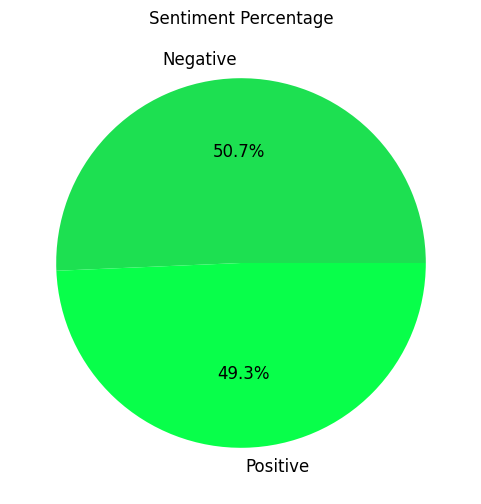

In [6]:
sentiment_percentage(Corpus, 'Sentiment', (6, 6))

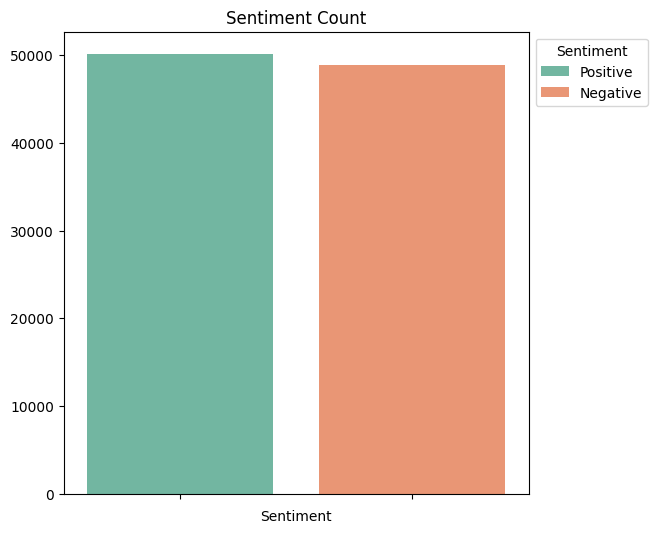

In [7]:
sentiment_counts(Corpus, 'Sentiment', (6, 6))

# Number Of Sentences

In [8]:
Corpus['NumberOfSentences'] = Corpus['Review'].apply(lambda n:len(sent_tokenize(n)))
Corpus.drop(Corpus[Corpus["NumberOfSentences"] == 0].index, inplace = True)
Corpus['NumberOfSentences'].sum()

170078

# Average Number Of Sentences

In [9]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

2

# Maximum Number Of Sentences

In [10]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

28

# Minimum Number Of Sentences

In [11]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# Number Of Words Before Text Normalization

In [12]:
Corpus["Number of Words 1"] = Corpus['Review'].apply(lambda n:len(tokenizer_.tokenize(n)))
Corpus["Number of Words 1"].sum()

6611170

# Average Number Of Words Before Text Normalization

In [13]:
AverageNaumberOfWords1 = int(np.round((Corpus["Number of Words 1"].mean())))
AverageNaumberOfWords1

67

# Maximum Number Of Word Before Text Normalization

In [14]:
MaximumNaumberOfWords1 = Corpus["Number of Words 1"].max()
MaximumNaumberOfWords1

197

# Minimum Number Of Words Before Text Normalization

In [15]:
MimimumNaumberOfWords1 = Corpus["Number of Words 1"].min()
MimimumNaumberOfWords1

1

In [16]:
Corpus[Corpus["Number of Words 1"] == 0]

,Sentiment,Review,NumberOfSentences,Number of Words 1


# Number Of Charachters Before Text Normalization

In [17]:
Corpus["Number of Charachters 1"] = Corpus['Review'].apply(lambda n:sum(chr.isalpha() for chr in n))
Corpus["Number of Charachters 1"].sum()

27988235

# Average Number Of Charachters Before Text Normalization

In [18]:
AverageNumberOfCharachters1 = int(np.round(Corpus["Number of Charachters 1"].mean()))
AverageNumberOfCharachters1

283

# Maximum Number Of Charachters Before Text Normalization

In [19]:
MaximumNumberOfCharachters1 = Corpus['Number of Charachters 1'].max() 
MaximumNumberOfCharachters1

850

# Minimum Number Of Charachters Before Text Normalization

In [20]:
MinimumNumberOfCharachters1 = Corpus['Number of Charachters 1'].min() 
MinimumNumberOfCharachters1

0

In [21]:
Corpus[Corpus['Number of Charachters 1']==0]

,Sentiment,Review,NumberOfSentences,Number of Words 1,Number of Charachters 1
21520,Negative,&#1605 ؛ &#1593 ؛&#1575 ؛ &#1604 ؛ &#1575 ؛ &#...,1,91,0


# Most Frequent Words Before Text Normalization

In [22]:
MostFrequentWord1 = Counter((Corpus['Review']).str.split().explode()).most_common(15)
MostFrequentWordDF1 = pd.DataFrame(MostFrequentWord1, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF1

,Word,Count
1,،,297581
2,من,191174
3,في,152504
4,على,108108
5,هذا,106711
6,أن,97085
7,إلى,56826
8,لا,55645
9,مع,35941
10,كان,35631


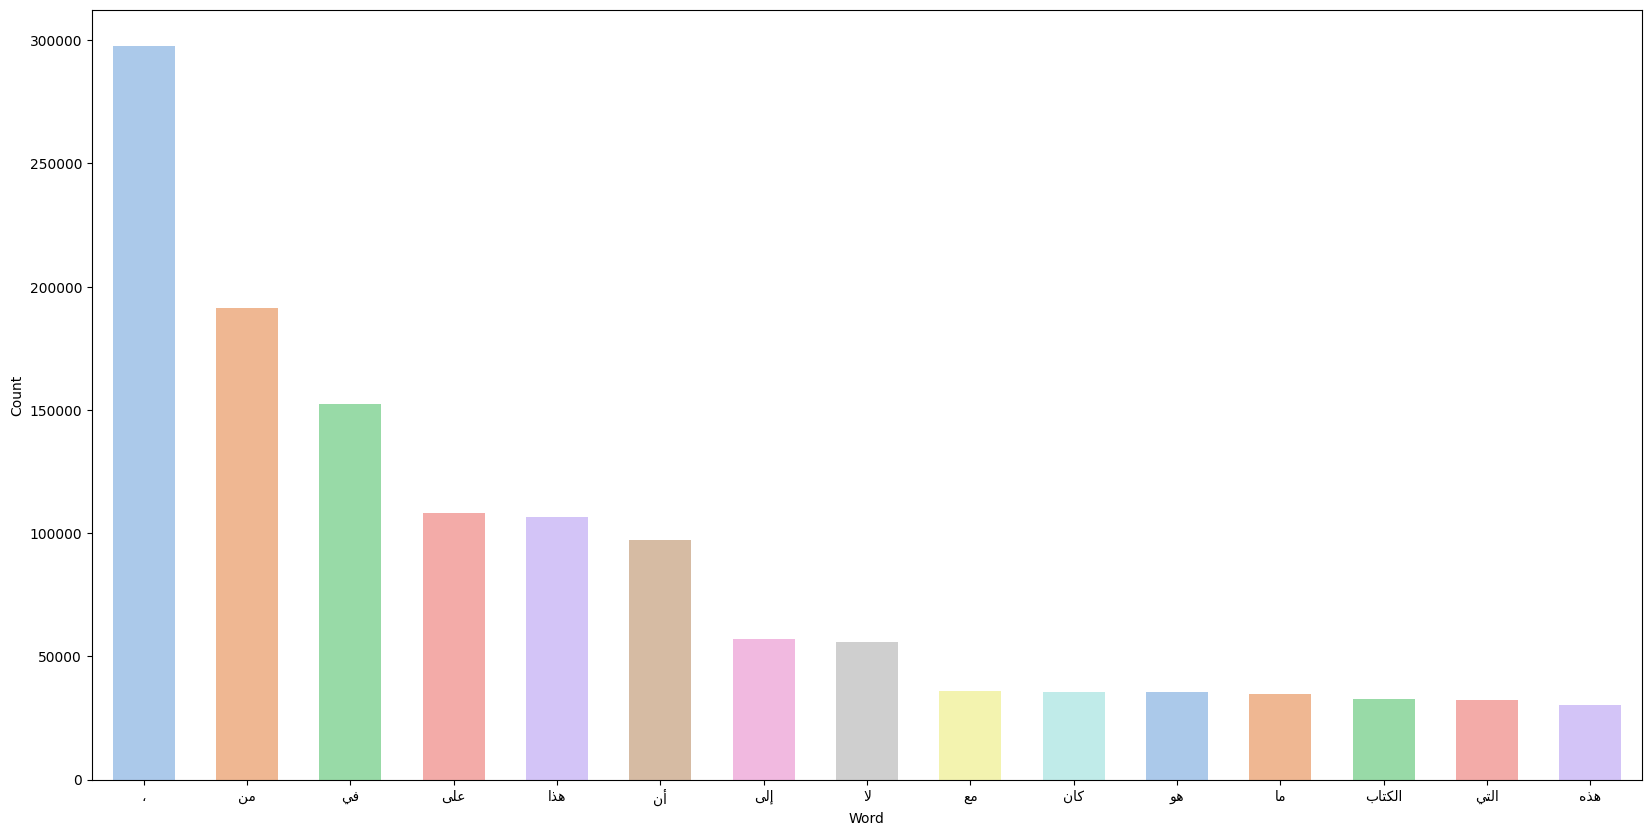

In [23]:
bar_plot(data=MostFrequentWordDF1, text = 'Word', x = 'Word', y='Count')

# Text Normalization

In [24]:
text_normalization = Text_Normalization(remove_emojis = True,
                                        remove_hashtags = True,
                                        remove_url = True,
                                        remove_mention = True,
                                        remove_html_tags = True,
                                        remove_new_line_char = True,
                                        remove_english_letter = True,
                                        remove_hindi_letter = True,
                                        remove_urdu_letter = True,
                                        remove_sindhi_letter = True,
                                        remove_hebrew_letter = True,
                                        remove_latin_letter = True,
                                        remove_unwanted_char = True,
                                        remove_arabic_diacritics = True,
                                        remove_arabic_tatweel = True,
                                        convert_gaf = True,
                                        convert_pe = True,
                                        convert_che = True,
                                        convert_ve = True,
                                        convert_alef = True,
                                        convert_alef_maqsura = True,
                                        convert_teh_marbuta = True,
                                        convert_ayin = True,
                                        convert_la = True,
                                        convert_kurdish_waw = True,
                                        remove_punctuations = True,
                                        normalize_arabic_unicode = True,
                                        remove_unicode_and_special_character = True,
                                        remove_stop_words = True,
                                        remove_number = True,
                                        remove_longest_than = True,
                                        remove_duplicate_word = True,
                                        remove_single_letter = True,
                                        remove_duplicated_letter = True,
                                        remove_whitespace = True
                                        )


In [25]:
Corpus['Normalized_Review'] = Corpus['Review'].map(lambda x: text_normalization.text_normalization(x))
Corpus.dropna(axis=1, inplace=True)
Corpus.to_csv('Normalized Corpus.csv')
Corpus.head()

,Sentiment,Review,NumberOfSentences,Number of Words 1,Number of Charachters 1,Normalized_Review
1,Negative,من كتب آخر 50 صفحة من هذا الكتاب؟- المفسد: سنة...,1,84,322,كتب اخر صفحه الكتاب فسد سنه العجائب كتاب رائع ...
2,Negative,عديمة الفائدة: من الصعب بالنسبة لي أن أتخيل ما...,1,81,317,عدي الفائده الصعب بالنسبه اتخيل يقي رب يكونون ...
3,Positive,نظرة عامة رائعة على الموسيقى التقليدية الفارسي...,1,140,622,نظره عا رائعه وسيقى التقليديه الفارسيه يسعدني ...
4,Positive,تمرين رائع: كشخص في حالة جيدة جدًا ، وضعني جيل...,1,105,447,رين رائع كشخص حاله جيده جد وضعني جيليان العار ...
5,Negative,ليس البديل الذي كنت أتوقعه: لم يكن هذا الحبل ا...,1,41,179,البديل اتوقعه الحبل البديل الجوده اتوقعها الاط...


# Number Of Unique Words

In [26]:
UniqueWords = set()
for word in Corpus['Normalized_Review'].str.split():
    UniqueWords.update(word)

len(UniqueWords)

106040

# WordCloud

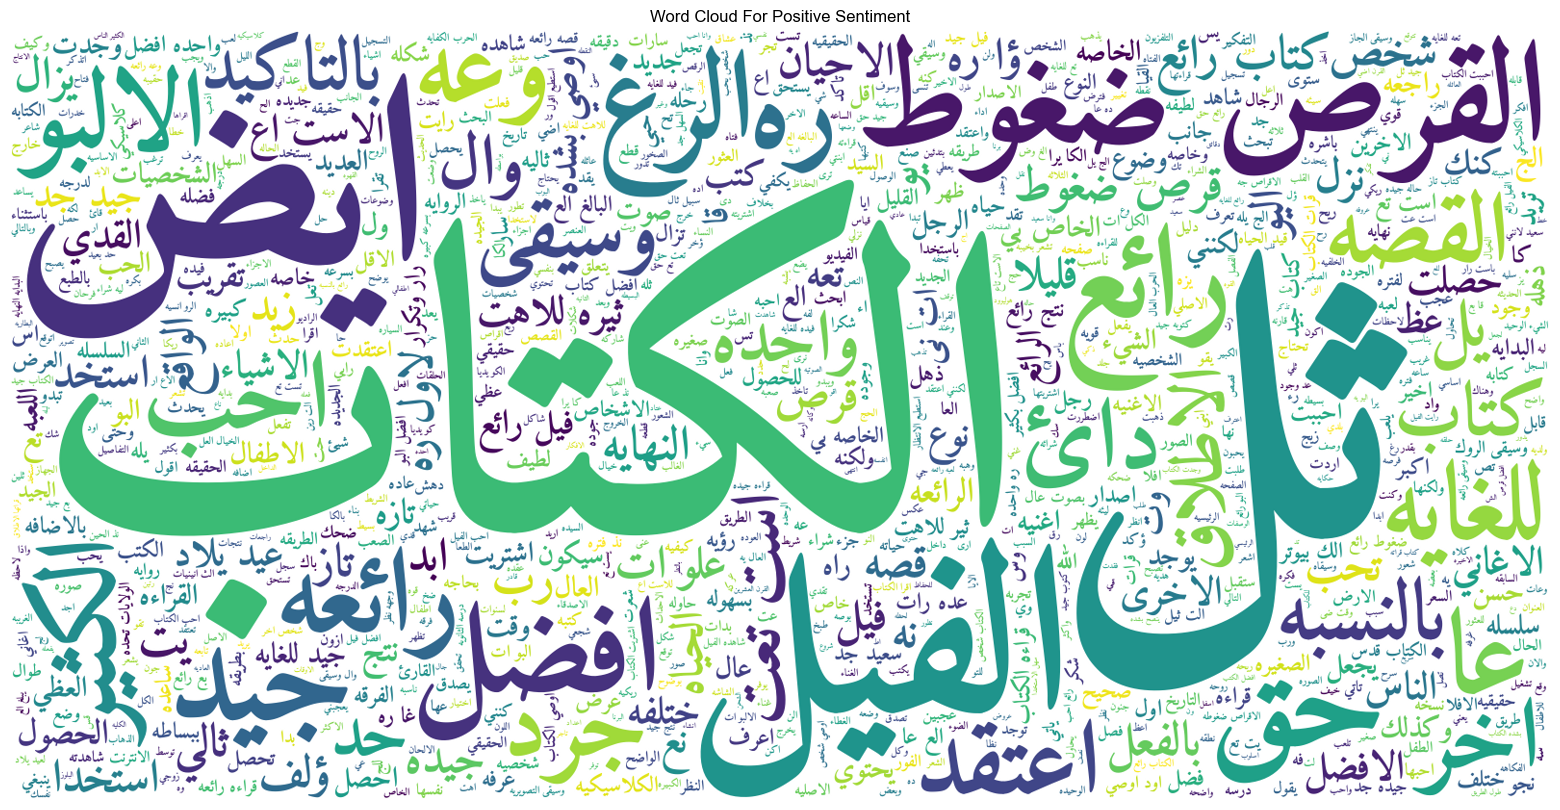

In [27]:
wordcloud(data=Corpus, target='Positive', width=1600, hieght=800, review='Normalized_Review', max_words= 1000)

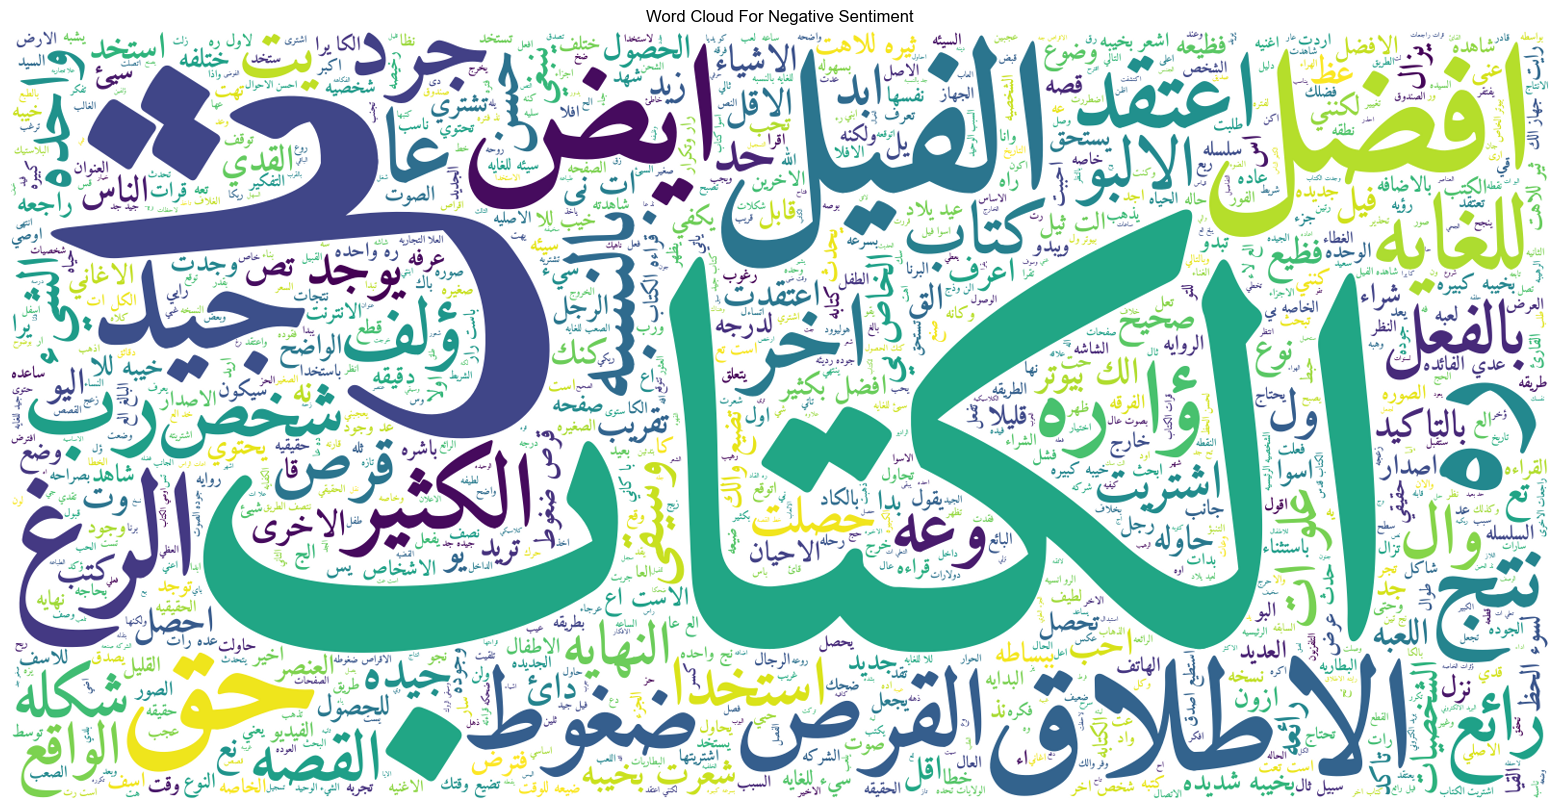

In [28]:
wordcloud(data=Corpus, target='Negative', width=1600, hieght=800, review='Normalized_Review', max_words= 1000)

# Number Of Words After Text Normalization

In [29]:
Corpus["Number of Words 2"] = Corpus["Normalized_Review"].apply(lambda n:len(tokenizer_.tokenize(n)))
Corpus.drop(Corpus[Corpus["Number of Words 2"] == 0].index, inplace = True)
Corpus["Number of Words 2"].sum()

3780922

# Average Number Of Words After Text Normalization

In [30]:
AverageNaumberOfWords2 = int(np.round((Corpus["Number of Words 2"].mean())))
AverageNaumberOfWords2

38

# Maximum Number Of Word After Text Normalization

In [31]:
MaximumNaumberOfWords2 = Corpus["Number of Words 2"].max()
MaximumNaumberOfWords2

121

# Minimum Number Of Words After Text Normalization

In [32]:
MimimumNaumberOfWords2 = Corpus["Number of Words 2"].min()
MimimumNaumberOfWords2

1

# Number Of Charachters After Text Normalization

In [33]:
Corpus["Number of Charachters 2"] = Corpus["Normalized_Review"].apply(lambda n:sum(chr.isalpha() for chr in n))
Corpus["Number of Charachters 2"].sum()

17548161

# Average Number Of Charachters After Text Normalization

In [34]:
AverageNumberOfCharachters2 = int(np.round(Corpus["Number of Charachters 2"].mean()))
AverageNumberOfCharachters2

177

# Maximum Number Of Charachters After Text Normalization

In [35]:
MaximumNumberOfCharachters2 = Corpus['Number of Charachters 2'].max() 
MaximumNumberOfCharachters2

596

# Minimum Number Of Charachters After Text Normalization

In [36]:
MinimumNumberOfCharachters2 = Corpus['Number of Charachters 2'].min() 
MinimumNumberOfCharachters2

2

# Most Frequent Words After Text Normalization

In [37]:
MostFrequentWord2 = Counter((Corpus['Normalized_Review']).str.split().explode()).most_common(15)
MostFrequentWordDF2 = pd.DataFrame(MostFrequentWord2, columns=('Word', 'Count'), index=range(1, 16))
MostFrequentWordDF2

,Word,Count
1,الكتاب,39757
2,للغايه,24079
3,جيد,22309
4,الفيل,21398
5,افضل,19942
6,رائع,19824
7,ره,19745
8,ثل,17949
9,ات,16556
10,كتاب,14503


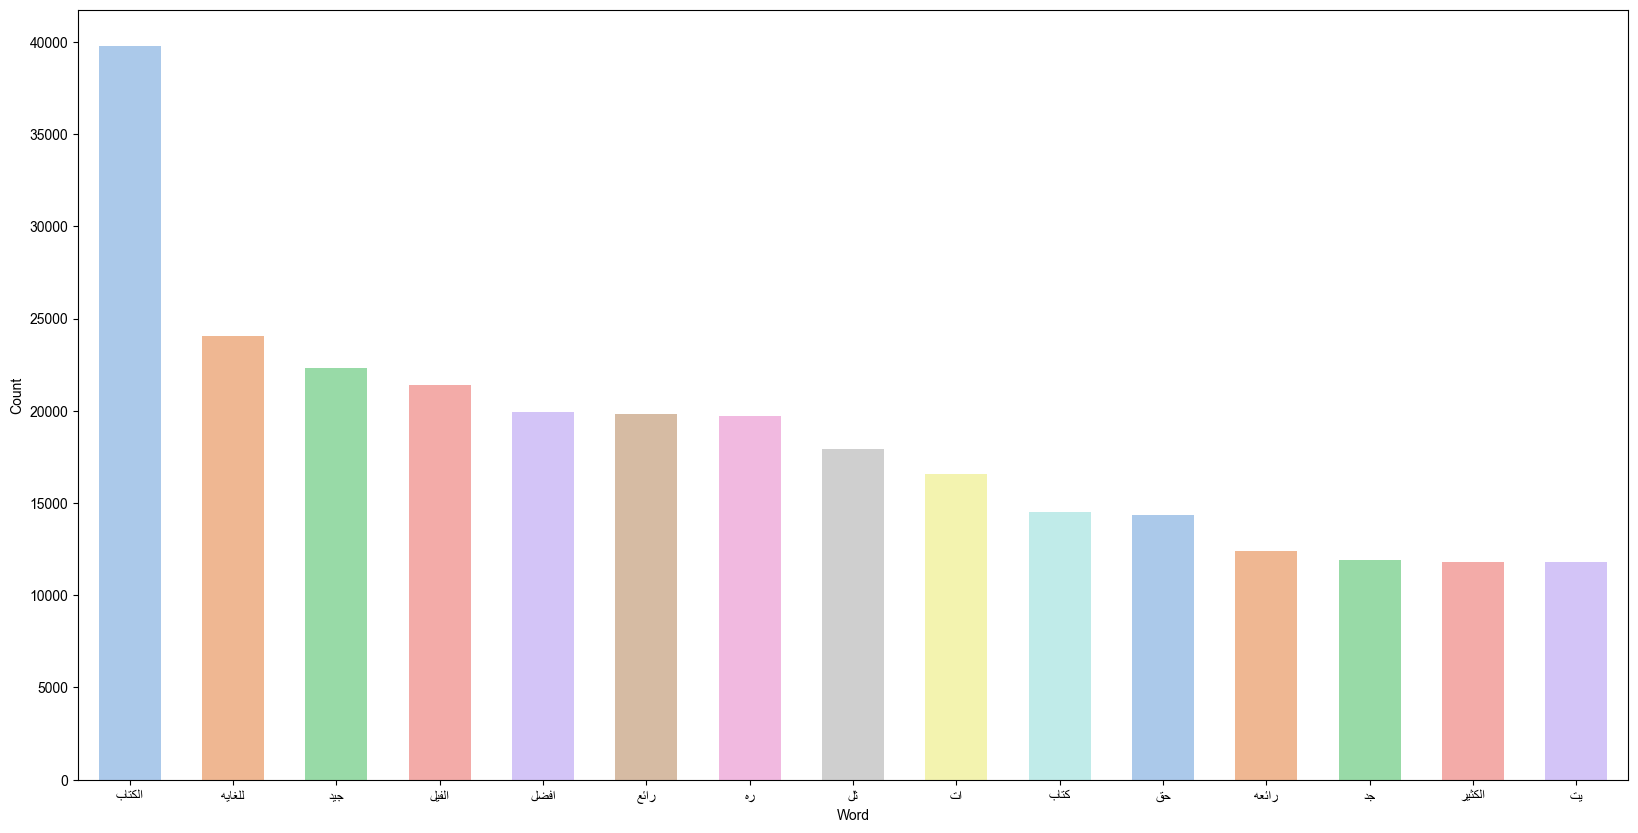

In [38]:
bar_plot(data=MostFrequentWordDF2, x = 'Word', y='Count' , text='Word')

# Most Frequent Words Of Each Sentiment

**1-Positive**

In [39]:
Positive = Corpus[Corpus['Sentiment'] == 'Positive']

In [40]:
PositiveMostFrequentWord = Counter((Positive['Normalized_Review']).str.split().explode()).most_common(10)
PositiveMostFrequentWordDF = pd.DataFrame(PositiveMostFrequentWord, columns=('Word', 'Count'), index=range(1, 11))
PositiveMostFrequentWordDF

,Word,Count
1,الكتاب,19676
2,رائع,15973
3,جيد,13602
4,افضل,12033
5,للغايه,11662
6,رائعه,9767
7,الفيل,9345
8,ره,8978
9,كتاب,8638
10,ثل,8467


**2-Negative**

In [41]:
Negative = Corpus[Corpus['Sentiment'] == 'Negative']

In [42]:
NegativeMostFrequentWord = Counter((Negative['Normalized_Review']).str.split().explode()).most_common(10)
NegativeMostFrequentWordDF = pd.DataFrame(NegativeMostFrequentWord, columns=('Word', 'Count'), index=range(1, 11))
NegativeMostFrequentWordDF

,Word,Count
1,الكتاب,20081
2,للغايه,12417
3,الفيل,12053
4,ره,10767
5,ثل,9482
6,جيد,8707
7,ات,8557
8,افضل,7909
9,يت,6758
10,حق,6479


# Bigrams

In [43]:
Corpus['Bigrams'] = Corpus['Normalized_Review'].apply(lambda x: list(nltk.bigrams(x.split( ))))
Corpus

,Sentiment,Review,NumberOfSentences,Number of Words 1,Number of Charachters 1,Normalized_Review,Number of Words 2,Number of Charachters 2,Bigrams
1,Negative,من كتب آخر 50 صفحة من هذا الكتاب؟- المفسد: سنة...,1,84,322,كتب اخر صفحه الكتاب فسد سنه العجائب كتاب رائع ...,45,200,"[(كتب, اخر), (اخر, صفحه), (صفحه, الكتاب), (الك..."
2,Negative,عديمة الفائدة: من الصعب بالنسبة لي أن أتخيل ما...,1,81,317,عدي الفائده الصعب بالنسبه اتخيل يقي رب يكونون ...,38,171,"[(عدي, الفائده), (الفائده, الصعب), (الصعب, بال..."
3,Positive,نظرة عامة رائعة على الموسيقى التقليدية الفارسي...,1,140,622,نظره عا رائعه وسيقى التقليديه الفارسيه يسعدني ...,88,423,"[(نظره, عا), (عا, رائعه), (رائعه, وسيقى), (وسي..."
4,Positive,تمرين رائع: كشخص في حالة جيدة جدًا ، وضعني جيل...,1,105,447,رين رائع كشخص حاله جيده جد وضعني جيليان العار ...,63,300,"[(رين, رائع), (رائع, كشخص), (كشخص, حاله), (حال..."
5,Negative,ليس البديل الذي كنت أتوقعه: لم يكن هذا الحبل ا...,1,41,179,البديل اتوقعه الحبل البديل الجوده اتوقعها الاط...,23,118,"[(البديل, اتوقعه), (اتوقعه, الحبل), (الحبل, ال..."
...,...,...,...,...,...,...,...,...,...
98996,Positive,أحد كتبي المفضلة: هذا الكتاب هو ما تم صنع الكت...,1,62,257,كتبي فضله الكتاب صنع الكتب اجله هديه كونراد لب...,37,176,"[(كتبي, فضله), (فضله, الكتاب), (الكتاب, صنع), ..."
98997,Negative,أعطي هذا النجم الواحد تحت الاحتجاج ، لا يستحق ...,1,45,169,اعطي النج الواحد الاحتجاج يستحق اعادت ترتيبها ...,21,107,"[(اعطي, النج), (النج, الواحد), (الواحد, الاحتج..."
98998,Negative,لن أشتري من هذا البائع مرة أخرى!: كان لدي المح...,2,26,105,اشتري البائع ره ده يو وسحب غطاء الكبل بعيد الن...,14,63,"[(اشتري, البائع), (البائع, ره), (ره, ده), (ده,..."
98999,Positive,Part Auto -Biography - دليل الرومانسية جزء: هن...,1,68,319,دليل الرو انسيه جزء الكثير لحياه جين سي ور الك...,41,199,"[(دليل, الرو), (الرو, انسيه), (انسيه, جزء), (ج..."


# Split The Dataset Into Dependent (X) And Independent (y)

In [44]:
X, y= Corpus['Normalized_Review'], Corpus['Sentiment']

# Encoding Dependent Variables (Y) Into Integer

In [45]:
le = LabelEncoder()
y = le.fit_transform(y)

# Split The Dataset Into Training And Testing

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42,  stratify=y)

# Vectorizer

In [47]:
Vectorizer = TfidfVectorizer()
X_train_Vec = Vectorizer.fit_transform(X_train)
X_test_Vec = Vectorizer.transform(X_test)

# Word Mapping

In [48]:
Word_mapping = Vectorizer.vocabulary_
Word_mapping_ =pd.DataFrame((list(Word_mapping.items())), columns=['Word', 'Mapping'])
Word_mapping_.head()

,Word,Mapping
0,طفولي,52317
1,زعج,44482
2,الهوبيت,18168
3,وجدته,86242
4,وسعيد,88847


# Machine Learning

**1-Naive Bayes**

In [49]:
Algorithm = MultinomialNB(alpha= 1)
model_1 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_1, X_train=X_train_Vec, y_train=y_train)

MultinomialNB(alpha=1)

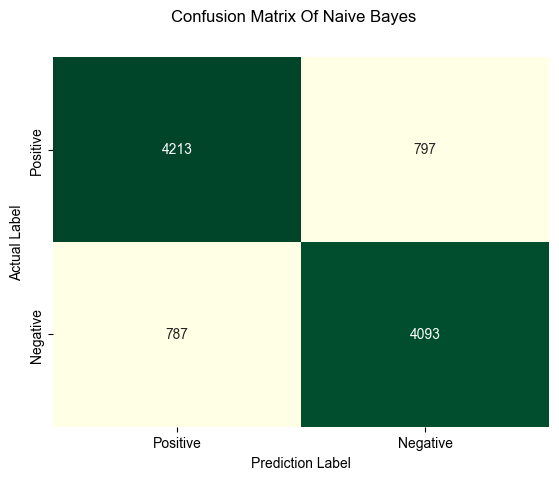

In [50]:
y_predNB = model_1.predict(X_test_Vec)
ConfusionMatrixNB = confusion_matrix_(y_test = y_test, y_pred = y_predNB)
confusion_matrix_display(confusion_matrix = ConfusionMatrixNB, name = 'Naive Bayes')
False_PositiveNB, True_PositiveNB, False_NegativeNB, True_NegativeNB = generate_poitive_negative(ConfusionMatrixNB)

In [51]:
AccuracyNB = accuracy_score(True_Positive = True_PositiveNB, True_Negative = True_NegativeNB, False_Positive =False_PositiveNB, False_Negative = False_NegativeNB)
PrecisionNB= precision_score(True_Positive = True_PositiveNB, False_Positive= False_PositiveNB)

SensitivityNB = sensitivity_score(True_Positive = True_PositiveNB,  False_Negative = False_NegativeNB)
SpecificityNB = specificity_score(True_Negative = True_NegativeNB, False_Positive = False_PositiveNB)

F1ScoreNB = f1_score(True_Positive = True_PositiveNB, False_Negative = False_NegativeNB, False_Positive = False_PositiveNB)
ErrorNB = error_rate(True_Positive = True_PositiveNB, True_Negative = True_NegativeNB, False_Positive =False_PositiveNB, False_Negative = False_NegativeNB)

In [52]:
performance_metrics_data_frame(Accuracy = AccuracyNB, Precision = PrecisionNB, Sensitivity = SensitivityNB, Specificity = SpecificityNB, F1Score = F1ScoreNB, Error = ErrorNB)

,Values
Accuracy,0.839838
Precision,0.840918
Sensitivity,0.842600
Specificity,0.837014
F1Score,0.841758
Error,0.160162


**2-Logistic Regression**

In [53]:
Algorithm = LogisticRegression()
model_2 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_2, X_train=X_train_Vec, y_train=y_train)

LogisticRegression()

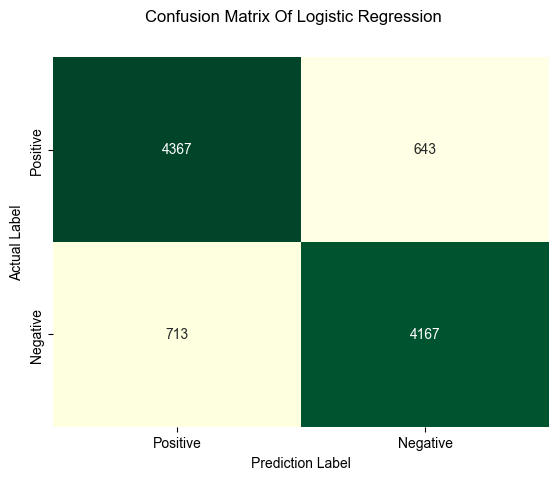

In [54]:
y_predLR = model_2.predict(X_test_Vec)
ConfusionMatrixLR = confusion_matrix_(y_test = y_test, y_pred = y_predLR)
confusion_matrix_display(confusion_matrix = ConfusionMatrixLR, name = 'Logistic Regression')
False_PositiveLR, True_PositiveLR, False_NegativeLR, True_NegativeLR = generate_poitive_negative(ConfusionMatrixLR)

In [55]:
AccuracyLR = accuracy_score(True_Positive = True_PositiveLR, True_Negative = True_NegativeLR, False_Positive =False_PositiveLR, False_Negative = False_NegativeLR)
PrecisionLR= precision_score(True_Positive = True_PositiveLR, False_Positive= False_PositiveLR)

SensitivityLR = sensitivity_score(True_Positive = True_PositiveLR,  False_Negative = False_NegativeLR)
SpecificityLR = specificity_score(True_Negative = True_NegativeLR, False_Positive = False_PositiveLR)

F1ScoreLR = f1_score(True_Positive = True_PositiveLR, False_Negative = False_NegativeLR, False_Positive = False_PositiveLR)
ErrorLR = error_rate(True_Positive = True_PositiveLR, True_Negative = True_NegativeLR, False_Positive =False_PositiveLR, False_Negative = False_NegativeLR)

In [56]:
performance_metrics_data_frame(Accuracy = AccuracyLR, Precision = PrecisionLR, Sensitivity = SensitivityLR, Specificity = SpecificityLR, F1Score = F1ScoreLR, Error = ErrorLR)

,Values
Accuracy,0.862892
Precision,0.871657
Sensitivity,0.859646
Specificity,0.866320
F1Score,0.865610
Error,0.137108


**3-Decision Tree**

In [57]:
Algorithm = DecisionTreeClassifier(criterion='gini', )
model_3 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_3, X_train=X_train_Vec, y_train=y_train)

DecisionTreeClassifier()

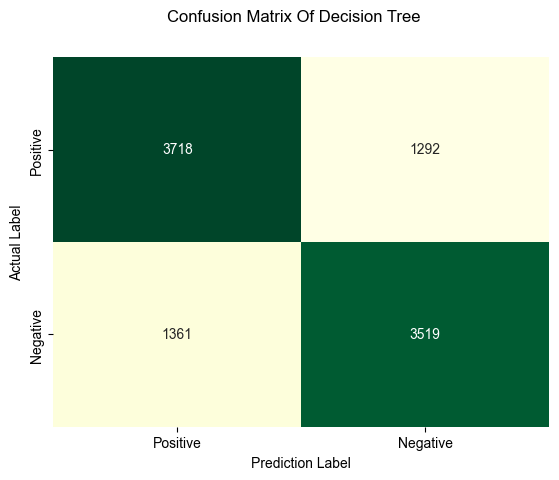

In [58]:
y_predDT = model_3.predict(X_test_Vec)
ConfusionMatrixDT = confusion_matrix_(y_test = y_test, y_pred = y_predDT)
confusion_matrix_display(confusion_matrix = ConfusionMatrixDT, name = 'Decision Tree')
False_PositiveDT, True_PositiveDT, False_NegativeDT, True_NegativeDT = generate_poitive_negative(ConfusionMatrixDT)

In [59]:
AccuracyDT = accuracy_score(True_Positive = True_PositiveDT, True_Negative = True_NegativeDT, False_Positive =False_PositiveDT, False_Negative = False_NegativeDT)
PrecisionDT= precision_score(True_Positive = True_PositiveDT, False_Positive =False_PositiveDT)

SensitivityDT = sensitivity_score(True_Positive = True_PositiveDT,  False_Negative = False_NegativeDT)
SpecificityDT = specificity_score(True_Negative = True_NegativeDT, False_Positive = False_PositiveDT)

F1ScoreDT = f1_score(True_Positive = True_PositiveDT, False_Negative = False_NegativeDT, False_Positive = False_PositiveDT)
ErrorDT = error_rate(True_Positive = True_PositiveDT, True_Negative = True_NegativeDT, False_Positive =False_PositiveDT, False_Negative = False_NegativeDT)

In [60]:
performance_metrics_data_frame(Accuracy = AccuracyDT, Precision = PrecisionDT, Sensitivity = SensitivityDT, Specificity = SpecificityDT, F1Score = F1ScoreDT, Error = ErrorDT)

,Values
Accuracy,0.731749
Precision,0.742116
Sensitivity,0.732034
Specificity,0.731449
F1Score,0.737040
Error,0.268251


**4-K Nearest Neighbors**

In [61]:
Algorithm =KNeighborsClassifier(metric='minkowski', n_neighbors=5, weights='distance', p=2)
model_4 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_4, X_train=X_train_Vec, y_train=y_train)

KNeighborsClassifier(weights='distance')

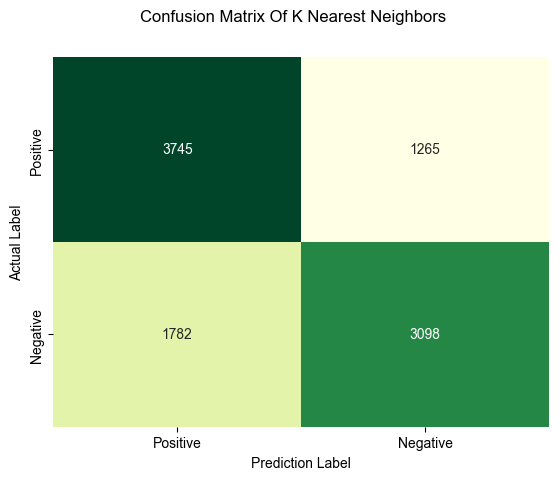

In [62]:
y_predKNN = model_4.predict(X_test_Vec)
ConfusionMatrixKNN = confusion_matrix_(y_test = y_test, y_pred = y_predKNN)
confusion_matrix_display(confusion_matrix = ConfusionMatrixKNN, name = 'K Nearest Neighbors')
False_PositiveKNN, True_PositiveKNN, False_NegativeKNN, True_NegativeKNN = generate_poitive_negative(ConfusionMatrixKNN)

In [63]:
AccuracyKNN = accuracy_score(True_Positive = True_PositiveKNN, True_Negative = True_NegativeKNN, False_Positive =False_PositiveKNN, False_Negative = False_NegativeKNN)
PrecisionKNN= precision_score(True_Positive = True_PositiveKNN, False_Positive =False_PositiveKNN)

SensitivityKNN = sensitivity_score(True_Positive = True_PositiveKNN,  False_Negative = False_NegativeKNN)
SpecificityKNN = specificity_score(True_Negative = True_NegativeKNN, False_Positive = False_PositiveKNN)

F1ScoreKNN = f1_score(True_Positive = True_PositiveKNN, False_Negative = False_NegativeKNN, False_Positive = False_PositiveKNN)
ErrorKNN = error_rate(True_Positive = True_PositiveKNN, True_Negative = True_NegativeKNN, False_Positive =False_PositiveKNN, False_Negative = False_NegativeKNN)

In [64]:
performance_metrics_data_frame(Accuracy = AccuracyKNN, Precision = PrecisionKNN, Sensitivity = SensitivityKNN, Specificity = SpecificityKNN, F1Score = F1ScoreKNN, Error = ErrorKNN)

,Values
Accuracy,0.691911
Precision,0.747505
Sensitivity,0.677583
Specificity,0.710062
F1Score,0.710829
Error,0.308089


**5-Random Forest**

In [65]:
Algorithm = RandomForestClassifier(criterion = 'entropy', n_estimators=100, )
model_5 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_5, X_train=X_train_Vec, y_train=y_train)

RandomForestClassifier(criterion='entropy')

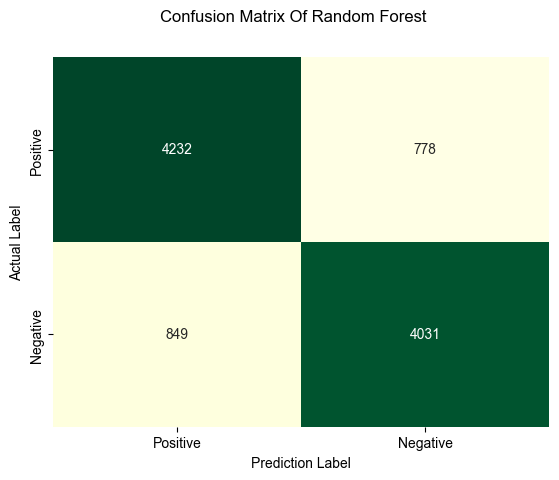

In [66]:
y_predRF = model_5.predict(X_test_Vec)
ConfusionMatrixRF = confusion_matrix_(y_test = y_test, y_pred = y_predRF)
confusion_matrix_display(confusion_matrix = ConfusionMatrixRF, name = 'Random Forest')
False_PositiveRF, True_PositiveRF, False_NegativeRF, True_NegativeRF = generate_poitive_negative(ConfusionMatrixRF)

In [67]:
AccuracyRF = accuracy_score(True_Positive = True_PositiveRF, True_Negative = True_NegativeRF, False_Positive =False_PositiveRF, False_Negative = False_NegativeRF)
PrecisionRF= precision_score(True_Positive = True_PositiveRF, False_Positive =False_PositiveRF)

SensitivityRF = sensitivity_score(True_Positive = True_PositiveRF,  False_Negative = False_NegativeRF)
SpecificityRF = specificity_score(True_Negative = True_NegativeRF, False_Positive = False_PositiveRF)

F1ScoreRF = f1_score(True_Positive = True_PositiveRF, False_Negative = False_NegativeRF, False_Positive = False_PositiveRF)
ErrorRF = error_rate(True_Positive = True_PositiveRF, True_Negative = True_NegativeRF, False_Positive =False_PositiveRF, False_Negative = False_NegativeRF)

In [68]:
performance_metrics_data_frame(Accuracy = AccuracyRF, Precision = PrecisionRF, Sensitivity = SensitivityRF, Specificity = SpecificityRF, F1Score = F1ScoreRF, Error = ErrorRF)

,Values
Accuracy,0.835490
Precision,0.844711
Sensitivity,0.832907
Specificity,0.838220
F1Score,0.838767
Error,0.164510


**6-SGD Classifier**

In [69]:
Algorithm = SGDClassifier(loss='hinge', )
model_6 = machine_learning_model(algorithm=Algorithm)
fit_model(model=model_6, X_train=X_train_Vec, y_train=y_train)

SGDClassifier()

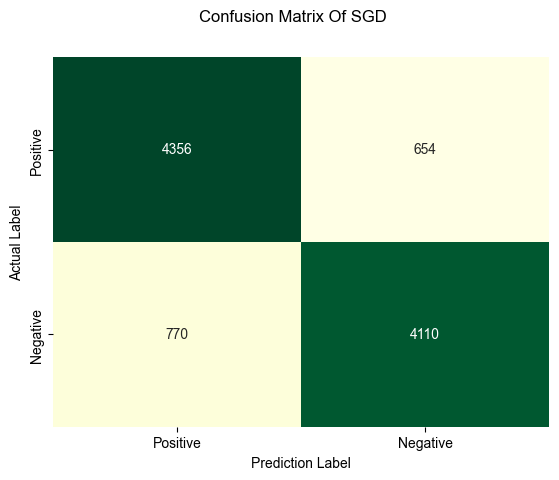

In [70]:
y_predSGD = model_6.predict(X_test_Vec)
ConfusionMatrixSGD = confusion_matrix_(y_test = y_test, y_pred = y_predSGD)
confusion_matrix_display(confusion_matrix = ConfusionMatrixSGD, name = 'SGD')
False_PositiveSGD, True_PositiveSGD, False_NegativeSGD, True_NegativeSGD = generate_poitive_negative(ConfusionMatrixSGD)

In [71]:
AccuracySGD = accuracy_score(True_Positive = True_PositiveSGD, True_Negative = True_NegativeSGD, False_Positive =False_PositiveSGD, False_Negative = False_NegativeSGD)
PrecisionSGD= precision_score(True_Positive = True_PositiveSGD, False_Positive =False_PositiveSGD)

SensitivitySGD = sensitivity_score(True_Positive = True_PositiveSGD,  False_Negative = False_NegativeSGD)
SpecificitySGD = specificity_score(True_Negative = True_NegativeSGD, False_Positive = False_PositiveSGD)

F1ScoreSGD = f1_score(True_Positive = True_PositiveSGD, False_Negative = False_NegativeSGD, False_Positive = False_PositiveSGD)
ErrorSGD = error_rate(True_Positive = True_PositiveSGD, True_Negative = True_NegativeSGD, False_Positive =False_PositiveSGD, False_Negative = False_NegativeSGD)

In [72]:
performance_metrics_data_frame(Accuracy = AccuracySGD, Precision = PrecisionSGD, Sensitivity = SensitivitySGD, Specificity = SpecificitySGD, F1Score = F1ScoreSGD, Error = ErrorSGD)

,Values
Accuracy,0.856016
Precision,0.869461
Sensitivity,0.849785
Specificity,0.862720
F1Score,0.859511
Error,0.143984


# Deep Learning

**1-Word To Integer (Tokenizer)**

In [73]:
all_words , words = data_words(data=(X_train.to_list() + X_test.to_list())) # Set With Unique Words And Find Number Of Unique Words
words_to_index = words_to_index_(words=words) # Convert Word To Integer Index
index_to_words = index_to_word_(words=words)
all_words

106042

**2-Data To Sequence**

In [74]:
X_train_sequences = text_to_sequence(word_index=words_to_index, data=X_train) # Convert Text Into Squences Of Integer
X_test_sequences = text_to_sequence(word_index=words_to_index, data=X_test) # Convert Text Into Squences Of Integer
max_length = len(max(X_train_sequences, key = len)) # Find Max Length

**3-Zero Padding**

In [75]:
encoded_X_train = sequences_padding(input_sequence=X_train_sequences, max_length=max_length, padding='pre') # Zero Padding (Add Zeros To Strat Of Sequence In Input Sequences To Make All Sequences In Same Length)
encoded_X_test = sequences_padding(input_sequence=X_test_sequences, max_length=max_length, padding='pre') # Zero Padding (Add Zeros To Strat Of Sequence In Input Sequences To Make All Sequences In Same Length)

In [76]:
print('The Vocab Size Is :', all_words)
print('')
print('The Max Length Is :', max_length)

The Vocab Size Is : 106042

The Max Length Is : 121


**4.Word Index**

In [77]:
Word_Index_ =pd.DataFrame(words_to_index.values(),  index = words_to_index.keys(), columns=['Index'])  
Word_Index_.head(10)

,Index
UNK,1
كعكات,2
الرونج,3
وترتديه,4
حولتني,5
وينهون,6
فونوروف,7
للارشادات,8
ورسائل,9
يعتبرها,10


**5-Word Occurrence**

In [78]:
word_count = word_counts(data=(X_train.to_list() + X_test.to_list())) # Number Of Occurrence Each Word
word_count_ =pd.DataFrame((list(word_count.items())), columns=['Word', 'Count'])
word_count_.head()

,Word,Count
0,الكتاب,39757
1,للغايه,24079
2,جيد,22309
3,الفيل,21398
4,افضل,19942


**6-Word Vector**

In [79]:
path = 'cc.ar.300.vec'
embedding_dim, word_vector = word_vector_(path, all_words, words_to_index)

# Deep Learing Models

**7-LSTM**

In [ ]:
model_7 =lstm_(vocab_size = all_words , embedding_dim = embedding_dim, max_length=max_length, units = 32, embeddings_matrix=word_vector)
model_compile(model=model_7)
history = model_fit(model=model_7, X_train=encoded_X_train, y_train=y_train, X_test=encoded_X_test, y_test=y_test, epochs=10, batch_size=32)
model_evaluate(model=model_7, x_test=encoded_X_test, y_test=y_test)
plot_changes(histoty=history)       

Epoch 1/10
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8101 - loss: 0.4003

**8-Bidirectional LSTM**

In [ ]:
model_8 = bidirectional_lstm(vocab_size =all_words, embedding_dim = embedding_dim, max_length=max_length, units = 64, embeddings_matrix=word_vector)
model_compile(model=model_8)
history = model_fit(model=model_8, X_train=encoded_X_train, y_train=y_train, X_test=encoded_X_test, y_test=y_test, epochs=10, batch_size=32)
model_evaluate(model=model_8, x_test=encoded_X_test, y_test=y_test)
plot_changes(histoty=history)

**9-GRU**

In [ ]:
model_9 = gru_(vocab_size = all_words, embedding_dim = embedding_dim, max_length=max_length, units = 64, embeddings_matrix=word_vector)
model_compile(model=model_9)
history = model_fit(model=model_9, X_train=encoded_X_train, y_train=y_train, X_test=encoded_X_test, y_test=y_test, epochs=10, batch_size=32)
model_evaluate(model=model_9, x_test=encoded_X_test, y_test=y_test)
plot_changes(histoty=history)

# Model Inference

**1-Naive Bayes**

In [ ]:
machine_learning_inference(model=model_1,vectorizer=Vectorizer, text = reviews)

**2-Logistic Regression**

In [ ]:
machine_learning_inference(model=model_2,vectorizer=Vectorizer, text = reviews)

**3-Decision Tree**

In [ ]:
machine_learning_inference(model=model_3,vectorizer=Vectorizer, text = reviews)

**4-K Nearest Neighbors**

In [ ]:
machine_learning_inference(model=model_4,vectorizer=Vectorizer, text = reviews)

**5-Random Forest**

In [ ]:
machine_learning_inference(model=model_5,vectorizer=Vectorizer, text = reviews)

**6-SGD Classifier**

In [ ]:
machine_learning_inference(model=model_6,vectorizer=Vectorizer, text = reviews)

**7-LSTM**

In [ ]:
deep_learning_inference(model = model_7, text = reviews, max_length = max_length, word_index = words_to_index)

**8-Bidirectional LSTM**

In [ ]:
deep_learning_inference(model = model_8, text = reviews, max_length = max_length, word_index = words_to_index)

**9-GRU**

In [ ]:
deep_learning_inference(model = model_9, text = reviews, max_length = max_length, word_index = words_to_index)

# Transformers

In [ ]:
sentiment_analysis_transformers(reviews)